In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import optuna



In [9]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Data transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Running on: cuda
Files already downloaded and verified
Files already downloaded and verified


In [10]:

# Load ResNet-18 model and modify the output layer for CIFAR-10
model = models.resnet18(pretrained=False)  # Set pretrained=True if using transfer learning
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify for 10 classes (CIFAR-10)
model = model.to(device)  # Move the model to GPU if available

# Define loss function and optimizer with a lower initial learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)  # Reduced from 0.1 to 0.01

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)



Epoch [1/30] - Train Loss: 1.7011, Train Acc: 39.16%, Test Loss: 1.6567, Test Acc: 48.68%
Epoch [2/30] - Train Loss: 1.3418, Train Acc: 52.32%, Test Loss: 1.1094, Test Acc: 60.06%
Epoch [3/30] - Train Loss: 1.1497, Train Acc: 59.17%, Test Loss: 1.0239, Test Acc: 64.13%
Epoch [4/30] - Train Loss: 1.0230, Train Acc: 63.85%, Test Loss: 0.9612, Test Acc: 66.97%
Epoch [5/30] - Train Loss: 0.9386, Train Acc: 66.83%, Test Loss: 0.8603, Test Acc: 70.35%
Epoch [6/30] - Train Loss: 0.8722, Train Acc: 69.34%, Test Loss: 0.8402, Test Acc: 70.19%
Epoch [7/30] - Train Loss: 0.8226, Train Acc: 71.13%, Test Loss: 0.7810, Test Acc: 72.87%
Epoch [8/30] - Train Loss: 0.7813, Train Acc: 72.66%, Test Loss: 0.7646, Test Acc: 73.52%
Epoch [9/30] - Train Loss: 0.7472, Train Acc: 73.81%, Test Loss: 0.7160, Test Acc: 75.35%
Epoch [10/30] - Train Loss: 0.7163, Train Acc: 75.07%, Test Loss: 0.6952, Test Acc: 76.09%
Epoch [11/30] - Train Loss: 0.6908, Train Acc: 75.98%, Test Loss: 0.7101, Test Acc: 75.59%
Epoch [1

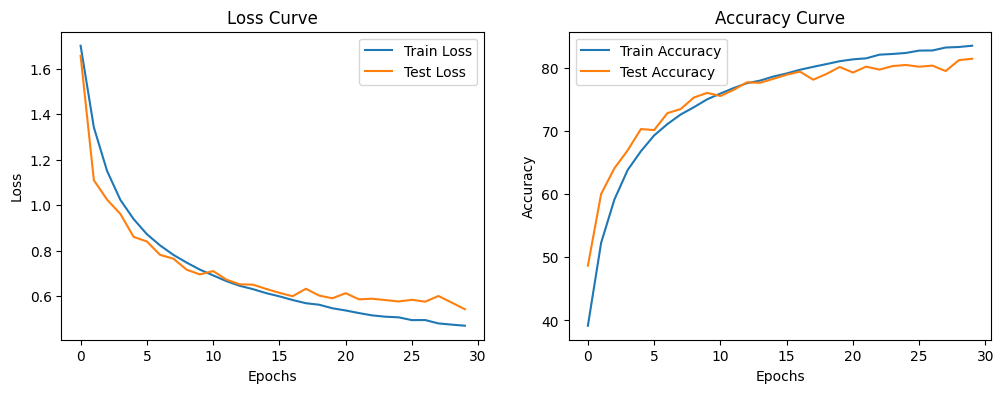

In [ ]:

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


In [ ]:

# Training loop
num_epochs = 30
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []


In [ ]:

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Adjust learning rate based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [11]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])

    # Update DataLoader with the suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False)

    # Training loop (with fewer epochs for tuning purposes)
    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, test_loader, criterion, device)
        scheduler.step(val_loss)
    
    # Return the validation accuracy for Optuna to maximize
    return val_acc

# Run the Optuna study to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Display the best parameters and validation accuracy
print("Best Hyperparameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)


[I 2024-11-02 20:34:53,351] A new study created in memory with name: no-name-48e80c31-464a-468d-8006-12dc5d545430
C:\Users\Antomiao\AppData\Local\Temp\ipykernel_18012\1413516547.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
C:\Users\Antomiao\AppData\Local\Temp\ipykernel_18012\1413516547.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
c:\Users\Antomiao\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please

Best Hyperparameters: {'lr': 0.00039191565148899795, 'batch_size': 32, 'weight_decay': 1.0510942277401435e-05, 'optimizer': 'Adam'}
Best Validation Accuracy: 78.93


In [ ]:
# Retrieve the best hyperparameters
best_params = study.best_params

# Update DataLoader with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Initialize model with the best hyperparameters
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

# Define loss function and optimizer with the best hyperparameters
criterion = nn.CrossEntropyLoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], momentum=0.9, weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop with best hyperparameters
num_epochs = 30
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    scheduler.step(test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Plot final training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


Epoch [1/30] - Train Loss: 1.5807, Train Acc: 42.48%, Test Loss: 1.2139, Test Acc: 55.45%
Epoch [2/30] - Train Loss: 1.2294, Train Acc: 56.01%, Test Loss: 1.0770, Test Acc: 62.33%
Epoch [3/30] - Train Loss: 1.0631, Train Acc: 62.59%, Test Loss: 0.9055, Test Acc: 68.49%
Epoch [4/30] - Train Loss: 0.9512, Train Acc: 66.92%, Test Loss: 0.8849, Test Acc: 69.69%
Epoch [5/30] - Train Loss: 0.8757, Train Acc: 69.46%, Test Loss: 0.8833, Test Acc: 69.88%
Epoch [6/30] - Train Loss: 0.8134, Train Acc: 71.65%, Test Loss: 0.7457, Test Acc: 73.73%
Epoch [7/30] - Train Loss: 0.7649, Train Acc: 73.49%, Test Loss: 0.7008, Test Acc: 75.86%
Epoch [8/30] - Train Loss: 0.7195, Train Acc: 75.08%, Test Loss: 0.7277, Test Acc: 75.43%
Epoch [9/30] - Train Loss: 0.6915, Train Acc: 76.12%, Test Loss: 0.6598, Test Acc: 77.22%
Epoch [10/30] - Train Loss: 0.6597, Train Acc: 77.29%, Test Loss: 0.6336, Test Acc: 78.26%
Epoch [11/30] - Train Loss: 0.6285, Train Acc: 78.34%, Test Loss: 0.6346, Test Acc: 78.01%
Epoch [1